TEORIA

Marco Teórico del Proyecto
a. Tablas termodinámicas y su importancia

Las tablas termodinámicas del agua son importantes en ingeniería y física porque presentan propiedades y condiciones específicas de presión, temperatura y entropía. Sus usos pueden ser en analisis industriales, investigacion y desarrollo y ciclos de potencias, que se dedican a calcular la eficiencia de un sistema, enccontrando el trabajo util que puede hacer una maquina o el estado en que se encontrara el agua en un momento especifico de un experimento.
Estas tablas incluyen magnitudes como:

Entalpía (h): Energía asociada al contenido calorífico del sistema.

Entropía (s): Medida del desorden molecular y la irreversibilidad de los procesos.

Volumen específico (v): Volumen ocupado por unidad de masa.

Energía interna (u): Energía contenida dentro del sistema debido al movimiento y a las interacciones moleculares.

El problema principal es que estas tablas presentan valores previamente estructurados con grandes diferencias de magnitud entre unos y otros, pero en la práctica se necesitan propiedades en condiciones intermedias que no siempre aparecen en la tabla.

b. Interpolación en termodinámica

La interpolación es un método matemático que permite estimar valores intermedios a partir de datos conocidos. En este proyecto se aplicará para calcular propiedades del agua cuando no estan en las listas termodinamicas del agua con puntos tabulados.

Los métodos más comunes son:

Interpolación lineal: Aproxima los valores en un intervalo con una recta. Es simple y rápida.

Interpolación cúbica (Cubic Spline): Ajusta curvas suaves que pasan por todos los puntos tabulados, siendo más precisa que la lineal.

Lagrange y Hermite: Métodos polinomiales que permiten mayor exactitud en casos específicos.


1. Interpolacion vapor saturado

Se limpian los valores con comas del csv para convertirlos en flotantes y poderlos manipular.

Se ha decidido usar la interpolación cúbica (CubicSpline)

Para el diagrama con curvas usado en busca del estado en que se encuentra el agua en el estado saturado, que puede variar entre una mezcla, gas o liquido, se toma como la mas eficiente.

Su desventaja seria en zonas con cambios bruscos, como el punto critico de la misma grafica. Probando los diferentes metodos se puede ver que no hay una diferencia clara en los resultados, entonces se siguio usando este metodo por cuestiones del uso de graficas, aunque realmente los cuatro metodos cumplian con los resultados esperados de una interpolacion no muy compleja.

Se compara la entropía ingresada por el usuario con los valores de entropía de líquido saturado

s < sf : liquido comprimido

sf < s < sg : Mezcla liquido-vapor

sg < s : vapor sobrecalentado

Se muestra una tabla que presenta el resultado interpolado junto a sus valores cercanos, de forma que se pueda comparar lo obtenido con un valor real y ver si tiene sentido el resultado.

Ingrese la TEMPERATURA [°C] (Max 373°C): 373
Ingrese la ENTROPÍA [kJ/(kg·K)]: 2

 Tabla con 2 anteriores, interpolado y 2 posteriores alrededor de T = 373.0 °C:
    T  P(MPa)       vf       vg     uf     ug  u_fg     hf     hg  h_fg     sf     sg   s_fg
365.0  19.821 0.002017 0.006012 1777.8 2303.7 525.9 1817.8 2422.9 605.2 4.0014 4.9497 0.9483
370.0  21.044 0.002215 0.004954 1844.1 2230.2 386.1 1890.7 2334.5 443.8 4.1112 4.8012 0.6901
373.0  21.814 0.002508 0.004045 1915.0 2141.6 226.6 1969.7 2229.8 260.1 4.2308 4.6334 0.4026

 Propiedades interpoladas a T = 373.00 °C:
  P(MPa): 21.814
  vf: 0.0025083
  vg: 0.004045
  uf: 1915
  ug: 2141.6
  u_fg: 226.6
  hf: 1969.7
  hg: 2229.8
  h_fg: 260.1
  sf: 4.2308
  sg: 4.6334
  s_fg: 0.4026

 Entropía dada: s = 2.0 kJ/(kg·K)
   Valores interpolados: sf = 4.2308, sg = 4.6334
   Estado físico estimado: Líquido comprimido


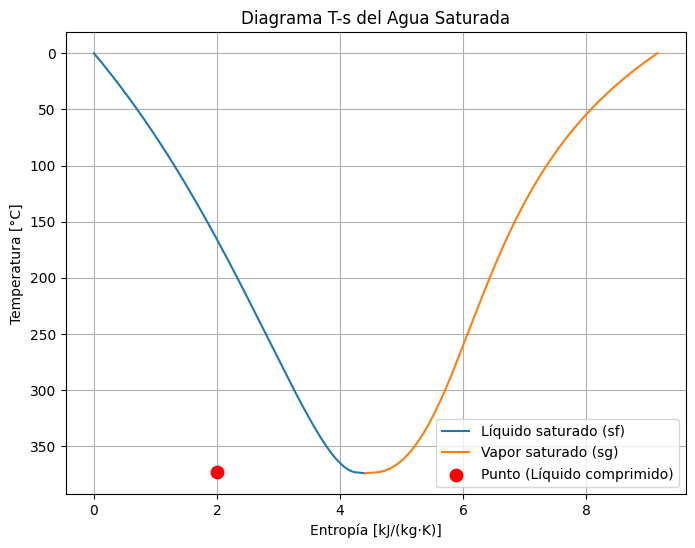

In [6]:
import pandas as pd
import numpy as np
import re
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

# Subir la carpeta
filename = "/content/saturated_by_temperature_V1.5.csv"

# Leer CSV y renombrar columnas
df = pd.read_csv(filename, skiprows=6)
df.columns = [
    "T", "P(MPa)",
    "vf", "vg",
    "uf", "ug", "u_fg",
    "hf", "hg", "h_fg",
    "sf", "sg", "s_fg"
]

# Limpiar los datos de la tabla y convertir a float
def to_float(x):
    s = str(x).strip()
    s = re.sub(r"[^0-9eE\.\-\+]", "", s)
    try:
        return float(s)
    except:
        return np.nan

for col in df.columns:
    df[col] = df[col].apply(to_float)
df = df.dropna().reset_index(drop=True)

# Crear funciones de interpolación usando CubicSpline
interps = {
    col: CubicSpline(df["T"], df[col], extrapolate=True)
    for col in df.columns if col != "T"
}

# Clasificar estado físico según entropía
def clasificar_estado(s, sf, sg):
    if s < sf:
        return "Líquido comprimido"
    elif sf <= s <= sg:
        return "Mezcla líquido-vapor"
    else:
        return "Vapor sobrecalentado"

# Entrada del usuario
T_user = float(input("Ingrese la TEMPERATURA [°C] (Max 373°C): "))
s_user = float(input("Ingrese la ENTROPÍA [kJ/(kg·K)]: "))

# Filtrar temperaturas múltiplos de 5
df_5 = df[df["T"] % 5 == 0].reset_index(drop=True)
T_vals = df_5["T"].values
idx = np.searchsorted(T_vals, T_user)

# Obtener 2 valores antes y 2 después
i0 = max(0, idx - 2)
i1 = min(len(T_vals), idx + 2)
vecinos = df_5.iloc[i0:i1].copy()

# Crear fila interpolada
fila_interp = {col: float(f(T_user)) for col, f in interps.items()}
fila_interp["T"] = T_user

# Insertar la fila interpolada en orden
df_tabla = pd.concat([vecinos, pd.DataFrame([fila_interp])], ignore_index=True)
df_tabla = df_tabla.sort_values(by="T").reset_index(drop=True)

# Mostrar tabla con interpolado
print(f"\n Tabla con 2 anteriores, interpolado y 2 posteriores alrededor de T = {T_user} °C:")
print(df_tabla.to_string(index=False))

# Clasificación del estado físico
sf_val = fila_interp["sf"]
sg_val = fila_interp["sg"]
estado = clasificar_estado(s_user, sf_val, sg_val)

print(f"\n Propiedades interpoladas a T = {T_user:.2f} °C:")
for col, val in fila_interp.items():
    if col != "T":
        print(f"  {col}: {val:.6g}")

print(f"\n Entropía dada: s = {s_user} kJ/(kg·K)")
print(f"   Valores interpolados: sf = {sf_val:.6g}, sg = {sg_val:.6g}")
print(f"   Estado físico estimado: {estado}")

# Gráfica
plt.figure(figsize=(8,6))
plt.plot(df["sf"], df["T"], label="Líquido saturado (sf)")
plt.plot(df["sg"], df["T"], label="Vapor saturado (sg)")
plt.scatter(s_user, T_user, c='red', s=80, label=f"Punto ({estado})", zorder=5)
plt.xlabel("Entropía [kJ/(kg·K)]")
plt.ylabel("Temperatura [°C]")
plt.title("Diagrama T-s del Agua Saturada")
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()
plt.show()


Compressed liquid water

Se limpian los valores con comas del csv para convertirlos en flotantes y poderlos manipular.

En este caso la presion es importante y tambien debe ser seleccionada para poder interpolar respecto a la temperatura.
Se usan las columnas a magnitudes físicas reconocibles:

Presión
P [MPa]

Temperatura
T [°C]

Volumen específico
v [m³/kg]

Energía interna
u [kJ/kg]

Entalpía
h [kJ/kg]

Entropía
s [kJ/(kg·K)]

La entropia es mas lineal por la presion constante en los cambios de temperatura, por el factor Cp (Capacidad calorifica a presion constante) que mide la energía requerida para calentar una sustancia mientras se permite que se expanda a una presión constante.

Se vuelve a usar CubicSpline, de forma que se aplica interpolación para obtener funciones matemáticas continuas de la forma:

f(T) ≈ propiedad(T, P_fija)

Ingrese la PRESIÓN [MPa] (5,10,15,20,30,50): 5
Ingrese la TEMPERATURA [°C] (Max 380°C): 34

Propiedades a P = 5.0 MPa y T = 34.0 °C (Interpolado):
  v: 0.00100447
  u: 142.254
  h: 147.333
  s: 0.501134

Valores cercanos en la tabla para comparación:
  P    T        v          u          h        s
5.0  0.0 0.000999   0.100000   5.100000 0.000300
5.0 20.0 0.000999  83.900000  88.900000 0.296000
5.0 34.0 0.001004 142.253781 147.332951 0.501134
5.0 40.0 0.001007 167.300000 172.400000 0.587400
5.0 60.0 0.001020 251.200000 256.300000 0.865600


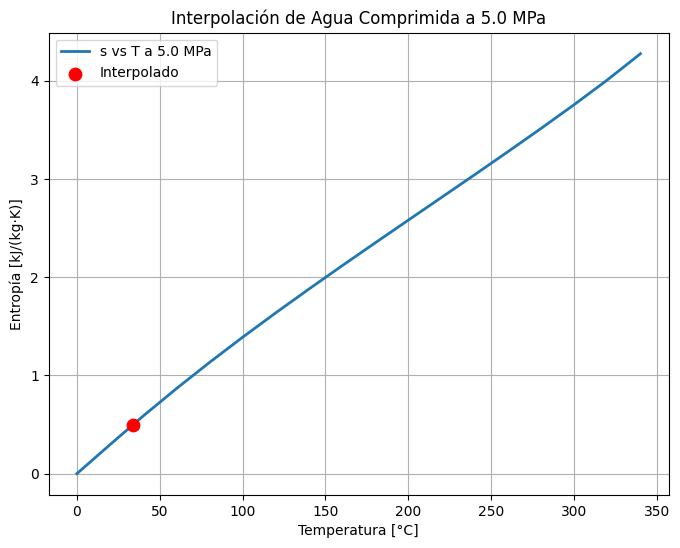

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Cargar datos
filename = "compressed.csv - Hoja 1.csv"

# Leer archivo, saltando encabezado
df_raw = pd.read_csv(filename, skiprows=1, header=None, names=["raw"])
df_split = df_raw["raw"].str.split(",", expand=True)

# Renombrar columnas
df_split.columns = ["P (MPa)", "T (°C)", "v (m³/kg)", "u (kJ/kg)", "h (kJ/kg)", "s (kJ/kg·K)"]

# Reemplazar comas decimales por puntos y convertir a float
for col in df_split.columns:
    df_split[col] = df_split[col].str.replace(",", ".", regex=False).astype(float)

# Renombrar columnas
df = df_split.rename(columns={
    "P (MPa)": "P",
    "T (°C)": "T",
    "v (m³/kg)": "v",
    "u (kJ/kg)": "u",
    "h (kJ/kg)": "h",
    "s (kJ/kg·K)": "s"
})

# ENTRADA DEL USUARIO
P_user = float(input("Ingrese la PRESIÓN [MPa] (5,10,15,20,30,50): "))
T_user = float(input("Ingrese la TEMPERATURA [°C] (Max 380°C): "))

# Filtrar por presion
df_presion = df[df["P"] == P_user].copy()

if df_presion.empty:
    print(f"No hay datos para P = {P_user} MPa en la tabla.")
else:
    # Ordenar y eliminar duplicados en T
    df_presion = df_presion.sort_values(by="T").drop_duplicates(subset="T").reset_index(drop=True)

    # Crear interpoladores
    interps = {
        col: CubicSpline(df_presion["T"], df_presion[col], extrapolate=True)
        for col in df_presion.columns if col not in ["T", "P"]
    }

    # Obtener vecinos más cercanos (2 antes, 2 después)
    T_vals = df_presion["T"].values
    idx = np.searchsorted(T_vals, T_user)
    i0 = max(0, idx - 2)
    i1 = min(len(T_vals), idx + 2)
    vecinos = df_presion.iloc[i0:i1].copy()

    # Interpolacion
    fila_interp = {col: float(f(T_user)) for col, f in interps.items()}
    fila_interp["T"] = T_user
    fila_interp["P"] = P_user

    # Insertar y ordenar
    df_tabla = pd.concat([vecinos, pd.DataFrame([fila_interp])], ignore_index=True)
    df_tabla = df_tabla.sort_values(by="T").reset_index(drop=True)

    # Mostrar resultados
    print(f"\nPropiedades a P = {P_user} MPa y T = {T_user} °C (Interpolado):")
    for k, v in fila_interp.items():
        if k not in ["T", "P"]:
            print(f"  {k}: {v:.6g}")

    print(f"\nValores cercanos en la tabla para comparación:")
    print(df_tabla.to_string(index=False))

    # GRAFICA T vs s
    plt.figure(figsize=(8,6))
    plt.plot(df_presion["T"], df_presion["s"], label=f"s vs T a {P_user} MPa", lw=2)
    plt.scatter(T_user, fila_interp["s"], c='red', s=80, label="Interpolado", zorder=5)
    plt.xlabel("Temperatura [°C]")
    plt.ylabel("Entropía [kJ/(kg·K)]")
    plt.title(f"Interpolación de Agua Comprimida a {P_user} MPa")
    plt.grid(True)
    plt.legend()
    plt.show()

Superheated water

Se limpian los valores con comas del csv para convertirlos en flotantes y poderlos manipular.
De nuevo se usa una preseleccion de la presión que nuevamente será constante, y se vuelve a interpolar respecto a la temperatura ingresada.

Muestras los valores cercanos de la tabla junto al interpolado, lo que sirve para verificar si el resultado tiene sentido, y se realiza una grafica T-s, lo cual es muy útil en vapor sobrecalentado porque la variación de entropía con la temperatura ya no es tan lineal como en el agua comprimida. Esto se debe nuevamente al Cp que ahora es mas dependiente de la temperatura gracias a
 ∫(Cp(T)/T)dT
 que a presiones constantes sufre mas la variacion de T que el liquido comprimido.

Ingrese la PRESIÓN [MPa] (0.5,1.,2.,5.,10.,20.,30.,40.,50.): 5
Ingrese la TEMPERATURA [°C] (Max 1300°C): 402

Propiedades de vapor sobrecalentado a P = 5.0 MPa y T = 402.0 °C (Interpolado):
  v: 0.0580654
  u: 2911.29
  h: 3201.62
  s: 6.6556

Valores cercanos en la tabla para comparación:
  P     T        v           u           h        s
5.0 350.0 0.051970 2809.500000 3069.300000 6.451600
5.0 400.0 0.057840 2907.500000 3196.700000 6.648300
5.0 402.0 0.058065 2911.293875 3201.622109 6.655603
5.0 450.0 0.063320 3000.600000 3317.200000 6.821000
5.0 500.0 0.068580 3091.800000 3434.700000 6.978100


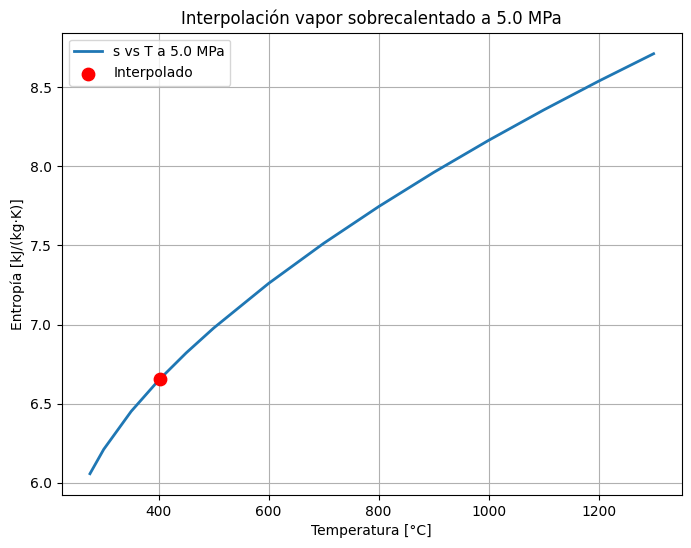

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# Cargar datos
filename = "superheated - Hoja 1.csv"

# Leer archivo, saltando encabezado
df_raw = pd.read_csv(filename, skiprows=1, header=None, names=["raw"])
df_split = df_raw["raw"].str.split(",", expand=True)

# Ajustar nombres de columnas para vapor sobrecalentado
df_split.columns = ["P (MPa)", "T (°C)", "v (m³/kg)", "u (kJ/kg)", "h (kJ/kg)", "s (kJ/kg·K)"]

# Reemplazar comas decimales por puntos y convertir a float
for col in df_split.columns:
    df_split[col] = df_split[col].str.replace(",", ".", regex=False).astype(float)

# Renombrar columnas
df = df_split.rename(columns={
    "P (MPa)": "P",
    "T (°C)": "T",
    "v (m³/kg)": "v",
    "u (kJ/kg)": "u",
    "h (kJ/kg)": "h",
    "s (kJ/kg·K)": "s"
})

# ENTRADA DEL USUARIO
P_user = float(input("Ingrese la PRESIÓN [MPa] (0.5,1.,2.,5.,10.,20.,30.,40.,50.): "))
T_user = float(input("Ingrese la TEMPERATURA [°C] (Max 1300°C): "))

# Filtrar por presion
df_presion = df[df["P"] == P_user].copy()

if df_presion.empty:
    print(f"No hay datos para P = {P_user} MPa en la tabla.")
else:
    # Ordenar y eliminar duplicados en T
    df_presion = df_presion.sort_values(by="T").drop_duplicates(subset="T").reset_index(drop=True)

    # Crear interpoladores para cada propiedad excepto T y P
    interps = {
        col: CubicSpline(df_presion["T"], df_presion[col], extrapolate=True)
        for col in df_presion.columns if col not in ["T", "P"]
    }

    # Buscar vecinos cercanos (2 antes, 2 despues)
    T_vals = df_presion["T"].values
    idx = np.searchsorted(T_vals, T_user)
    i0 = max(0, idx - 2)
    i1 = min(len(T_vals), idx + 2)
    vecinos = df_presion.iloc[i0:i1].copy()

    # Interpolacion
    fila_interp = {col: float(f(T_user)) for col, f in interps.items()}
    fila_interp["T"] = T_user
    fila_interp["P"] = P_user

    # Insertar y ordenar
    df_tabla = pd.concat([vecinos, pd.DataFrame([fila_interp])], ignore_index=True)
    df_tabla = df_tabla.sort_values(by="T").reset_index(drop=True)

    # MOSTRAR RESULTADOS
    print(f"\nPropiedades de vapor sobrecalentado a P = {P_user} MPa y T = {T_user} °C (Interpolado):")
    for k, v in fila_interp.items():
        if k not in ["T", "P"]:
            print(f"  {k}: {v:.6g}")

    print(f"\nValores cercanos en la tabla para comparación:")
    print(df_tabla.to_string(index=False))

    # GRAFICA T vs s
    plt.figure(figsize=(8,6))
    plt.plot(df_presion["T"], df_presion["s"], label=f"s vs T a {P_user} MPa", lw=2)
    plt.scatter(T_user, fila_interp["s"], c='red', s=80, label="Interpolado", zorder=5)
    plt.xlabel("Temperatura [°C]")
    plt.ylabel("Entropía [kJ/(kg·K)]")
    plt.title(f"Interpolación vapor sobrecalentado a {P_user} MPa")
    plt.grid(True)
    plt.legend()
    plt.show()